In [2]:
library(Seurat)
library(Signac)
library(dplyr)
library(ggplot2)
library(GenomicRanges)
library(ggforce)
library(BSgenome.Hsapiens.UCSC.hg38)
library(data.table)
library(biomaRt)
library(pheatmap)
library(GenomicRanges)

Loading required package: SeuratObject

Loading required package: sp




Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin

In [3]:
sobj <- readRDS('{PATH_1}')DefaultAssay(sobj) <- "ATAC"Idents(sobj) <- "treatment_and_guidecapture"

In [4]:
table(Idents(sobj))


     DASA_NT    DASA_HIC2   DASA_PIAS1    DASA_CHD2 DASA_GPBP1L1   DASA_PQBP1 
        2615          375          309          226          131          102 
  DASA_KMT2B    DASA_SLTM  DASA_PLAGL2  DASA_YEATS4    DASA_ADNP    DASA_BRD2 
         210          221           83          121           15           32 
 DASA_ZNF669   DMSO_KMT2B    DMSO_CHD2      DMSO_NT    DMSO_BRD2 DMSO_GPBP1L1 
          79          152           51         1661          148          222 
   DMSO_HIC2   DMSO_PIAS1   DMSO_ZBED6  DMSO_YEATS4  DMSO_ZNF669    DMSO_ADNP 
         216          299          126          241          121           98 
   DMSO_SLTM     DMSO_MNT 
         113           27 

In [5]:
colnames(sobj@meta.data)

[1] "nCount_ATAC"                 "nFeature_ATAC"              
 [3] "nCount_RNA"                  "nFeature_RNA"               
 [5] "orig.ident"                  "percent.mt"                 
 [7] "nucleosome_signal"           "nucleosome_percentile"      
 [9] "TSS.enrichment"              "TSS.percentile"             
[11] "nCount_SCT"                  "nFeature_SCT"               
[13] "predicted_doublets"          "doublet_scores"             
[15] "ATAC_snn_res.0.8"            "seurat_clusters"            
[17] "SCT.weight"                  "ATAC.weight"                
[19] "wsnn_res.0.8"                "guidecapture_classification"
[21] "S.Score"                     "G2M.Score"                  
[23] "Phase"                       "old.ident"                  
[25] "SCT_snn_res.0.8"             "Perturbation"               
[27] "isNT"                        "mixscape_class"             
[29] "mixscape_class_p_kd"         "mixscape_class.global"      
[31] "sample"                      "treatment"                  
[33] "treatment_and_guidecapture"  "nCount_PRTB"                
[35] "nFeature_PRTB"

In [6]:
# Get genes we're interested in
genes <- names(table(sobj$guidecapture_classification))
# Use gsub to remove "-*" (a hyphen and any characters that follow it) from each string
genes <- gsub("-.*", "", genes)

genes

[1] "ADNP"    "BRD2"    "CHD2"    "CHD2"    "GPBP1L1" "HIC2"    "HIC2"   
 [8] "HIC2"    "KMT2B"   "MNT"     "NT"      "PIAS1"   "PIAS1"   "PLAGL2" 
[15] "PLAGL2"  "PQBP1"   "SLTM"    "YEATS4"  "YEATS4"  "YEATS4"  "ZBED6"  
[22] "ZNF669"

In [7]:
# listMarts()
ensembl <- useMart("ensembl")
datasets <- listDatasets(ensembl)
ensembl <- useDataset("hsapiens_gene_ensembl", mart = ensembl)

In [8]:
getPromoterCoordinates <- function(tss, strand, upstream = 2000, downstream = 500) {
  if (strand == 1) {
    start <- ifelse(tss - upstream > 0, tss - upstream, 1)
    end <- tss + downstream
  } else {
    start <- tss - downstream
    end <- ifelse(tss + upstream > 0, tss + upstream, 1)
  }
  
  return(list(start = start, end = end))
}


In [9]:
attributes <- c('hgnc_symbol', 'chromosome_name', 'transcription_start_site', 'strand')

filters <- 'hgnc_symbol'

results <- getBM(attributes = attributes, filters = filters, values = genes, mart = ensembl)


In [10]:
promoterCoordinates <- lapply(1:nrow(results), function(i) {
  row <- results[i,]
  coords <- getPromoterCoordinates(row$transcription_start_site, row$strand)
  c(gene = row$hgnc_symbol, chromosome = row$chromosome_name, start = coords$start, end = coords$end)
})

# Convert the list back to a data frame
promoterCoordinates <- do.call(rbind, promoterCoordinates)


In [11]:
promoterCoordinates <- as.data.frame(promoterCoordinates)

In [12]:
head(promoterCoordinates)

,gene,chromosome,start,end
,<chr>,<chr>,<chr>,<chr>
1,ADNP,20,50905058,50907558
2,ADNP,20,50930937,50933437
3,ADNP,20,50928232,50930732
4,ADNP,20,50930875,50933375
5,ADNP,20,50930921,50933421
6,ADNP,20,50909291,50911791


In [13]:
# Filter for main chrs
main_chromosomes <- as.character(c(1:22, "X", "Y"))
filtered_promoterCoordinates <- promoterCoordinates[promoterCoordinates$chromosome %in% main_chromosomes, ]
head(filtered_promoterCoordinates)

,gene,chromosome,start,end
,<chr>,<chr>,<chr>,<chr>
1,ADNP,20,50905058,50907558
2,ADNP,20,50930937,50933437
3,ADNP,20,50928232,50930732
4,ADNP,20,50930875,50933375
5,ADNP,20,50930921,50933421
6,ADNP,20,50909291,50911791


In [14]:
df <- filtered_promoterCoordinates
# Assuming your data frame is named df
# Convert start and end columns to numeric if they are not already
df$start <- as.numeric(as.character(df$start))
df$end <- as.numeric(as.character(df$end))

# First, check that each gene is associated with only one chromosome
gene_chromosome_check <- df %>%
  group_by(gene) %>%
  summarise(chromosomes = n_distinct(chromosome)) %>%
  filter(chromosomes > 1)

# If any gene is associated with more than one chromosome, print a warning
if (nrow(gene_chromosome_check) > 0) {
  print("Warning: The following genes are associated with more than one chromosome:")
  print(gene_chromosome_check$gene)
} else {
  # If the check passes, proceed with the aggregation
  result <- df %>%
    group_by(gene, chromosome) %>%
    summarise(minstart = min(start, na.rm = TRUE), 
              maxend = max(end, na.rm = TRUE),
              .groups = 'drop') %>%
    # Add a new column in the desired format
    mutate(region = paste0("chr", chromosome, "-", minstart, "-", maxend))

  # View the result
  print(result)
}


# A tibble: 14 × 5
   gene    chromosome  minstart    maxend region                  
   <chr>   <chr>          <dbl>     <dbl> <chr>                   
 1 ADNP    20          50905058  50933437 chr20-50905058-50933437 
 2 BRD2    6           32966594  32980182 chr6-32966594-32980182  
 3 CHD2    15          92884203  93012928 chr15-92884203-93012928 
 4 GPBP1L1 1           45629215  45690113 chr1-45629215-45690113  
 5 HIC2    22          21415371  21442960 chr22-21415371-21442960 
 6 KMT2B   19          35715973  35738136 chr19-35715973-35738136 
 7 MNT     17           2387798   2403104 chr17-2387798-2403104   
 8 PIAS1   15          68052309  68192182 chr15-68052309-68192182 
 9 PLAGL2  20          32207243  32209743 chr20-32207243-32209743 
10 PQBP1   X           48888197  48899010 chrX-48888197-48899010  
11 SLTM    15          58886507  58935679 chr15-58886507-58935679 
12 YEATS4  12          69357710  69360279 chr12-69357710-69360279 
13 ZBED6   1          203793623 203796123 c

In [15]:
options(repr.plot.width = 10, repr.plot.height = 70)
# commented out to make later plots, uncomment to make this plots
# p1 <- CoveragePlot(sobj, 
#     region = result$region,
#     extend.upstream = 0,
#     extend.downstream = 0,
#     nrow = 11) 
# p1

In [16]:
gr_region <- sub("-", ":", result$region)
gr_region

[1] "chr20:50905058-50933437"  "chr6:32966594-32980182"  
 [3] "chr15:92884203-93012928"  "chr1:45629215-45690113"  
 [5] "chr22:21415371-21442960"  "chr19:35715973-35738136" 
 [7] "chr17:2387798-2403104"    "chr15:68052309-68192182" 
 [9] "chr20:32207243-32209743"  "chrX:48888197-48899010"  
[11] "chr15:58886507-58935679"  "chr12:69357710-69360279" 
[13] "chr1:203793623-203796123" "chr1:247103778-247106372"

In [17]:
# Extract expression data for specified regions
counts <- sobj[["ATAC"]]@counts
feature.matrix <- FeatureMatrix(
  fragments = Fragments(sobj),
  features = GRanges(gr_region),
  cells = colnames(counts)
)

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [18]:
# # Calculate average expression per cell type
# # Assuming 'ident' is your cell type identity in the meta data
# average_expression <- AggregateData(
#   object = feature.matrix,
#   group.by = "treatment_and_guidecapture",
#   fun = mean
# )

In [19]:
all(Cells(sobj) == colnames(feature.matrix))

[1] TRUE

In [20]:
sobj[["ATAC_sub"]] = CreateAssayObject(feature.matrix)

In [21]:
DefaultAssay(sobj) = "ATAC_sub"

In [22]:
# Initialize an empty data frame to store results
cell_types <- levels(Idents(sobj))
gene_list <- rownames(sobj)
mean_expression <- data.frame(matrix(ncol = length(cell_types), nrow = length(gene_list)))
colnames(mean_expression) <- cell_types
rownames(mean_expression) <- rownames(sobj)

# Calculate mean expression
for (cell_type in cell_types) {
    temp <- subset(sobj, idents = cell_type)
    temp <- GetAssayData(temp, assay = "ATAC_sub")
    temp <- temp[rownames(temp) %in% gene_list,]
    mean_expression[, cell_type] <- rowMeans(temp)
}

In [23]:
all(rownames(mean_expression) == result$region)

[1] TRUE

In [24]:
rownames(mean_expression) = result$gene

In [25]:
mean_expression

,DASA_NT,DASA_HIC2,DASA_PIAS1,DASA_CHD2,DASA_GPBP1L1,DASA_PQBP1,DASA_KMT2B,DASA_SLTM,DASA_PLAGL2,DASA_YEATS4,⋯,DMSO_BRD2,DMSO_GPBP1L1,DMSO_HIC2,DMSO_PIAS1,DMSO_ZBED6,DMSO_YEATS4,DMSO_ZNF669,DMSO_ADNP,DMSO_SLTM,DMSO_MNT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP,0.7782027,0.7626667,0.8025890,0.8716814,0.8015267,0.8235294,0.7285714,0.8642534,0.8674699,0.80991736,⋯,0.6891892,0.7297297,0.5972222,0.7424749,0.9047619,0.66804979,0.6859504,0.5000000,0.7433628,0.7777778
BRD2,1.8940727,1.5040000,1.8446602,1.9247788,1.7709924,1.9019608,2.0142857,1.8552036,2.0843373,1.73553719,⋯,1.0743243,1.8783784,2.0555556,2.0100334,2.2222222,2.08713693,2.2066116,2.0000000,1.8318584,2.1111111
CHD2,0.8745698,0.7040000,0.8511327,0.9601770,0.7404580,0.8529412,0.7714286,0.8190045,1.1325301,0.90909091,⋯,0.9864865,0.8963964,0.8611111,0.8829431,1.0238095,1.02489627,1.0826446,0.9387755,0.9646018,1.0000000
GPBP1L1,1.1005736,1.0293333,0.9902913,1.1769912,0.5114504,1.0980392,1.0476190,1.2352941,1.2891566,1.08264463,⋯,1.1283784,0.5990991,1.1296296,1.0702341,1.3412698,1.05809129,1.5454545,1.3673469,0.9469027,1.0740741
HIC2,0.7567878,0.3493333,0.6440129,0.7256637,0.6870229,0.7352941,0.7523810,0.8461538,0.7951807,0.78512397,⋯,0.7702703,0.7387387,0.5370370,0.8561873,0.9126984,0.75103734,1.0661157,0.8367347,0.9292035,0.8518519
KMT2B,0.9151052,0.9173333,0.8284790,0.8584071,0.8244275,0.9411765,0.3047619,1.0000000,1.0963855,0.93388430,⋯,1.0743243,0.9639640,1.0509259,0.9498328,0.9285714,0.85892116,0.9338843,1.4387755,0.9823009,1.1481481
MNT,1.4022945,1.3493333,1.4239482,1.5044248,1.3664122,1.2450980,1.4619048,1.5429864,1.5903614,1.06611570,⋯,1.6013514,1.5900901,1.5555556,1.6588629,1.7857143,1.85477178,1.7768595,1.4795918,1.4247788,2.1851852
PIAS1,0.7556405,0.5973333,0.2491909,0.7123894,0.6641221,0.8333333,0.7666667,0.7466063,0.8674699,0.73553719,⋯,0.8851351,0.7792793,0.6851852,0.4816054,0.7936508,0.85477178,0.9917355,0.8163265,0.7345133,0.8148148
PLAGL2,0.5043977,0.4746667,0.4822006,0.5132743,0.5725191,0.3627451,0.4523810,0.6063348,0.1566265,0.42148760,⋯,0.3175676,0.4189189,0.3842593,0.3344482,0.3571429,0.33195021,0.3305785,0.3571429,0.4778761,0.1851852


In [31]:
# Sort columns
# Step 1: Extract substrings that come after the underscore
substrings <- sub(".*_", "", names(mean_expression))

# Step 2: Order the indices of these substrings, breaking ties alphabetically by the full column name
order_indices <- order(substrings, names(mean_expression))

# Step 3: Reorder the dataframe columns based on these indices
df_sorted <- mean_expression[, order_indices]

# Check the new order of column names
print(names(df_sorted))
colnames(mean_expression)

 [1] "DASA_ADNP"    "DMSO_ADNP"    "DASA_BRD2"    "DMSO_BRD2"    "DASA_CHD2"   
 [6] "DMSO_CHD2"    "DASA_GPBP1L1" "DMSO_GPBP1L1" "DASA_HIC2"    "DMSO_HIC2"   
[11] "DASA_KMT2B"   "DMSO_KMT2B"   "DMSO_MNT"     "DASA_NT"      "DMSO_NT"     
[16] "DASA_PIAS1"   "DMSO_PIAS1"   "DASA_PLAGL2"  "DASA_PQBP1"   "DASA_SLTM"   
[21] "DMSO_SLTM"    "DASA_YEATS4"  "DMSO_YEATS4"  "DMSO_ZBED6"   "DASA_ZNF669" 
[26] "DMSO_ZNF669" 


[1] "DASA_NT"      "DASA_HIC2"    "DASA_PIAS1"   "DASA_CHD2"    "DASA_GPBP1L1"
 [6] "DASA_PQBP1"   "DASA_KMT2B"   "DASA_SLTM"    "DASA_PLAGL2"  "DASA_YEATS4" 
[11] "DASA_ADNP"    "DASA_BRD2"    "DASA_ZNF669"  "DMSO_KMT2B"   "DMSO_CHD2"   
[16] "DMSO_NT"      "DMSO_BRD2"    "DMSO_GPBP1L1" "DMSO_HIC2"    "DMSO_PIAS1"  
[21] "DMSO_ZBED6"   "DMSO_YEATS4"  "DMSO_ZNF669"  "DMSO_ADNP"    "DMSO_SLTM"   
[26] "DMSO_MNT"

In [27]:
df_sorted

,DASA_ADNP,DMSO_ADNP,DASA_BRD2,DMSO_BRD2,DASA_CHD2,DMSO_CHD2,DASA_GPBP1L1,DMSO_GPBP1L1,DASA_HIC2,DMSO_HIC2,⋯,DMSO_PIAS1,DASA_PLAGL2,DASA_PQBP1,DASA_SLTM,DMSO_SLTM,DASA_YEATS4,DMSO_YEATS4,DMSO_ZBED6,DASA_ZNF669,DMSO_ZNF669
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP,0.2000000,0.5000000,0.56250,0.6891892,0.8716814,0.6862745,0.8015267,0.7297297,0.7626667,0.5972222,⋯,0.7424749,0.8674699,0.8235294,0.8642534,0.7433628,0.80991736,0.66804979,0.9047619,0.6202532,0.6859504
BRD2,2.0666667,2.0000000,0.62500,1.0743243,1.9247788,2.0392157,1.7709924,1.8783784,1.5040000,2.0555556,⋯,2.0100334,2.0843373,1.9019608,1.8552036,1.8318584,1.73553719,2.08713693,2.2222222,1.5063291,2.2066116
CHD2,0.8666667,0.9387755,0.59375,0.9864865,0.9601770,1.2745098,0.7404580,0.8963964,0.7040000,0.8611111,⋯,0.8829431,1.1325301,0.8529412,0.8190045,0.9646018,0.90909091,1.02489627,1.0238095,0.6835443,1.0826446
GPBP1L1,0.9333333,1.3673469,0.75000,1.1283784,1.1769912,1.1764706,0.5114504,0.5990991,1.0293333,1.1296296,⋯,1.0702341,1.2891566,1.0980392,1.2352941,0.9469027,1.08264463,1.05809129,1.3412698,0.7848101,1.5454545
HIC2,0.8666667,0.8367347,0.68750,0.7702703,0.7256637,0.7254902,0.6870229,0.7387387,0.3493333,0.5370370,⋯,0.8561873,0.7951807,0.7352941,0.8461538,0.9292035,0.78512397,0.75103734,0.9126984,0.4810127,1.0661157
KMT2B,0.9333333,1.4387755,0.68750,1.0743243,0.8584071,0.7058824,0.8244275,0.9639640,0.9173333,1.0509259,⋯,0.9498328,1.0963855,0.9411765,1.0000000,0.9823009,0.93388430,0.85892116,0.9285714,0.7215190,0.9338843
MNT,1.8000000,1.4795918,1.00000,1.6013514,1.5044248,1.3333333,1.3664122,1.5900901,1.3493333,1.5555556,⋯,1.6588629,1.5903614,1.2450980,1.5429864,1.4247788,1.06611570,1.85477178,1.7857143,1.1772152,1.7768595
PIAS1,0.4666667,0.8163265,0.65625,0.8851351,0.7123894,1.0588235,0.6641221,0.7792793,0.5973333,0.6851852,⋯,0.4816054,0.8674699,0.8333333,0.7466063,0.7345133,0.73553719,0.85477178,0.7936508,0.6075949,0.9917355
PLAGL2,0.3333333,0.3571429,0.40625,0.3175676,0.5132743,0.4117647,0.5725191,0.4189189,0.4746667,0.3842593,⋯,0.3344482,0.1566265,0.3627451,0.6063348,0.4778761,0.42148760,0.33195021,0.3571429,0.3797468,0.3305785


In [28]:
# sort df_sorted such that DASA cols come first and are in alphabetical order then DMSO cols in alphabetical order
dasa_cols <- grep("^DASA", names(df_sorted), value = TRUE)
dmso_cols <- grep("^DMSO", names(df_sorted), value = TRUE)

dasa_cols_sorted <- sort(dasa_cols)
dmso_cols_sorted <- sort(dmso_cols)

df_sorted <- df_sorted[, c(dasa_cols_sorted, dmso_cols_sorted)]

In [29]:
df_sorted

,DASA_ADNP,DASA_BRD2,DASA_CHD2,DASA_GPBP1L1,DASA_HIC2,DASA_KMT2B,DASA_NT,DASA_PIAS1,DASA_PLAGL2,DASA_PQBP1,⋯,DMSO_GPBP1L1,DMSO_HIC2,DMSO_KMT2B,DMSO_MNT,DMSO_NT,DMSO_PIAS1,DMSO_SLTM,DMSO_YEATS4,DMSO_ZBED6,DMSO_ZNF669
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP,0.2000000,0.56250,0.8716814,0.8015267,0.7626667,0.7285714,0.7782027,0.8025890,0.8674699,0.8235294,⋯,0.7297297,0.5972222,0.7697368,0.7777778,0.7477423,0.7424749,0.7433628,0.66804979,0.9047619,0.6859504
BRD2,2.0666667,0.62500,1.9247788,1.7709924,1.5040000,2.0142857,1.8940727,1.8446602,2.0843373,1.9019608,⋯,1.8783784,2.0555556,2.4078947,2.1111111,1.9861529,2.0100334,1.8318584,2.08713693,2.2222222,2.2066116
CHD2,0.8666667,0.59375,0.9601770,0.7404580,0.7040000,0.7714286,0.8745698,0.8511327,1.1325301,0.8529412,⋯,0.8963964,0.8611111,0.8355263,1.0000000,0.9759181,0.8829431,0.9646018,1.02489627,1.0238095,1.0826446
GPBP1L1,0.9333333,0.75000,1.1769912,0.5114504,1.0293333,1.0476190,1.1005736,0.9902913,1.2891566,1.0980392,⋯,0.5990991,1.1296296,1.3223684,1.0740741,1.1216135,1.0702341,0.9469027,1.05809129,1.3412698,1.5454545
HIC2,0.8666667,0.68750,0.7256637,0.6870229,0.3493333,0.7523810,0.7567878,0.6440129,0.7951807,0.7352941,⋯,0.7387387,0.5370370,1.0460526,0.8518519,0.8037327,0.8561873,0.9292035,0.75103734,0.9126984,1.0661157
KMT2B,0.9333333,0.68750,0.8584071,0.8244275,0.9173333,0.3047619,0.9151052,0.8284790,1.0963855,0.9411765,⋯,0.9639640,1.0509259,0.5394737,1.1481481,0.9066827,0.9498328,0.9823009,0.85892116,0.9285714,0.9338843
MNT,1.8000000,1.00000,1.5044248,1.3664122,1.3493333,1.4619048,1.4022945,1.4239482,1.5903614,1.2450980,⋯,1.5900901,1.5555556,1.9473684,2.1851852,1.5894040,1.6588629,1.4247788,1.85477178,1.7857143,1.7768595
PIAS1,0.4666667,0.65625,0.7123894,0.6641221,0.5973333,0.7666667,0.7556405,0.2491909,0.8674699,0.8333333,⋯,0.7792793,0.6851852,0.9868421,0.8148148,0.7844672,0.4816054,0.7345133,0.85477178,0.7936508,0.9917355
PLAGL2,0.3333333,0.40625,0.5132743,0.5725191,0.4746667,0.4523810,0.5043977,0.4822006,0.1566265,0.3627451,⋯,0.4189189,0.3842593,0.3223684,0.1851852,0.3497893,0.3344482,0.4778761,0.33195021,0.3571429,0.3305785


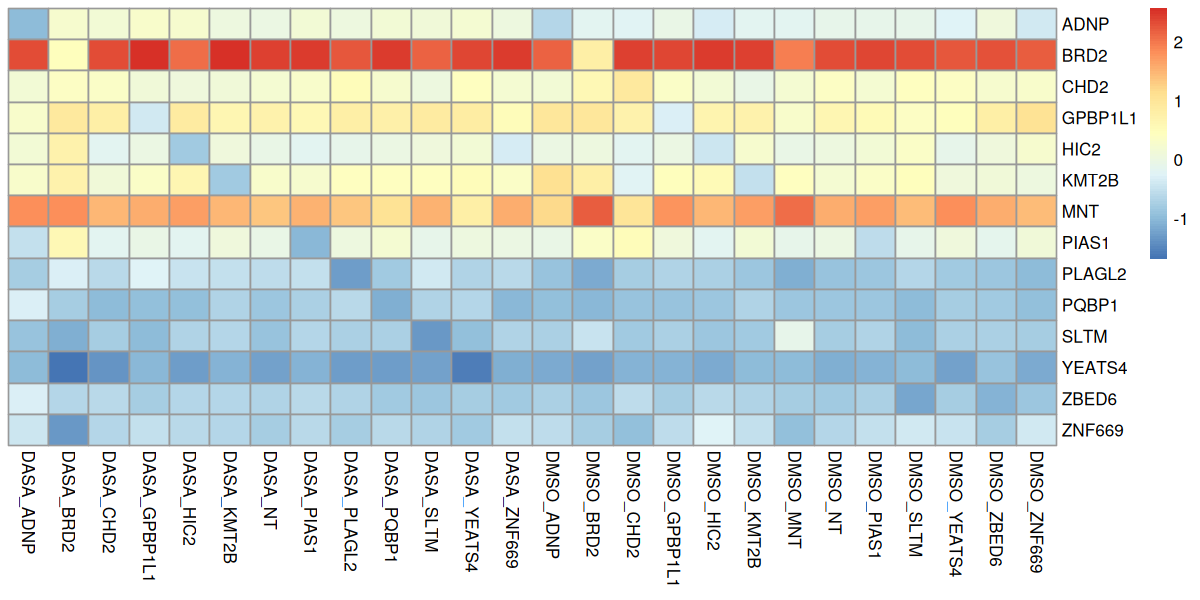

In [30]:
options(repr.plot.width = 10, repr.plot.height = 5)
pheatmap(scale(df_sorted), cluster_cols = FALSE, cluster_rows = FALSE)

# Worse plots

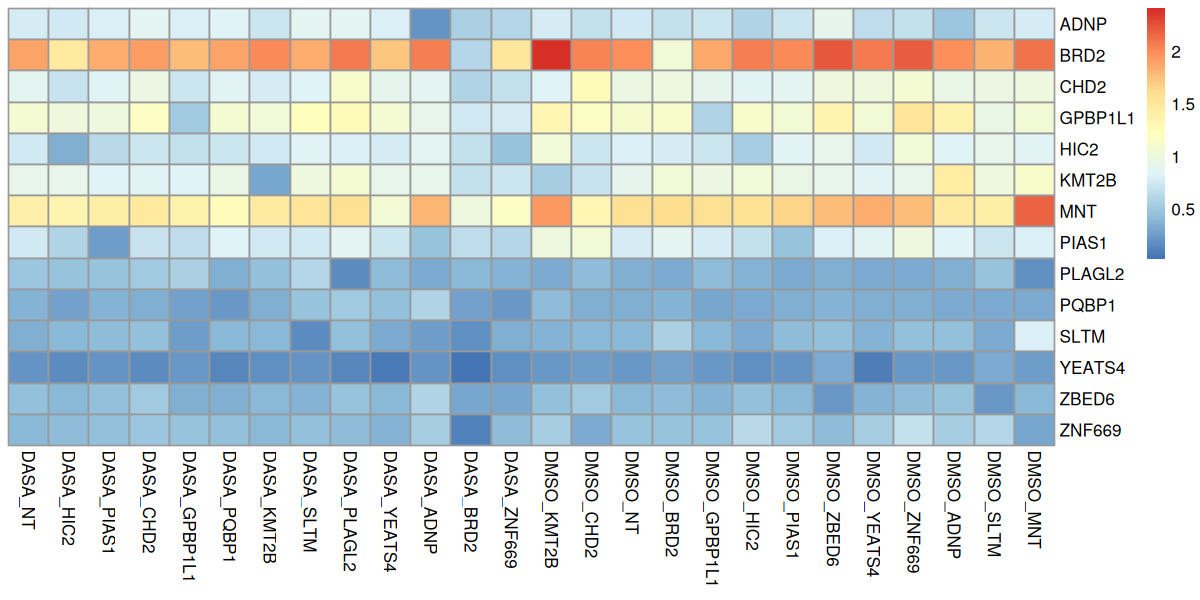

In [31]:
options(repr.plot.width = 10, repr.plot.height = 5)
pheatmap(mean_expression,cluster_cols = FALSE, cluster_rows = FALSE)

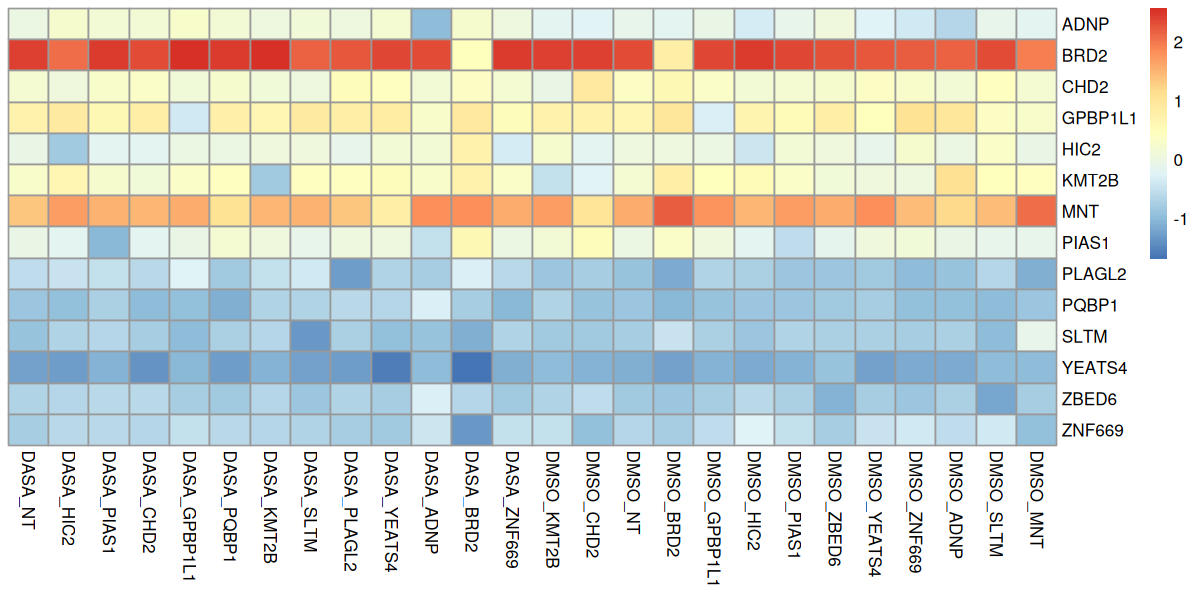

In [32]:
pheatmap(scale(mean_expression), cluster_cols = F, cluster_rows = F)

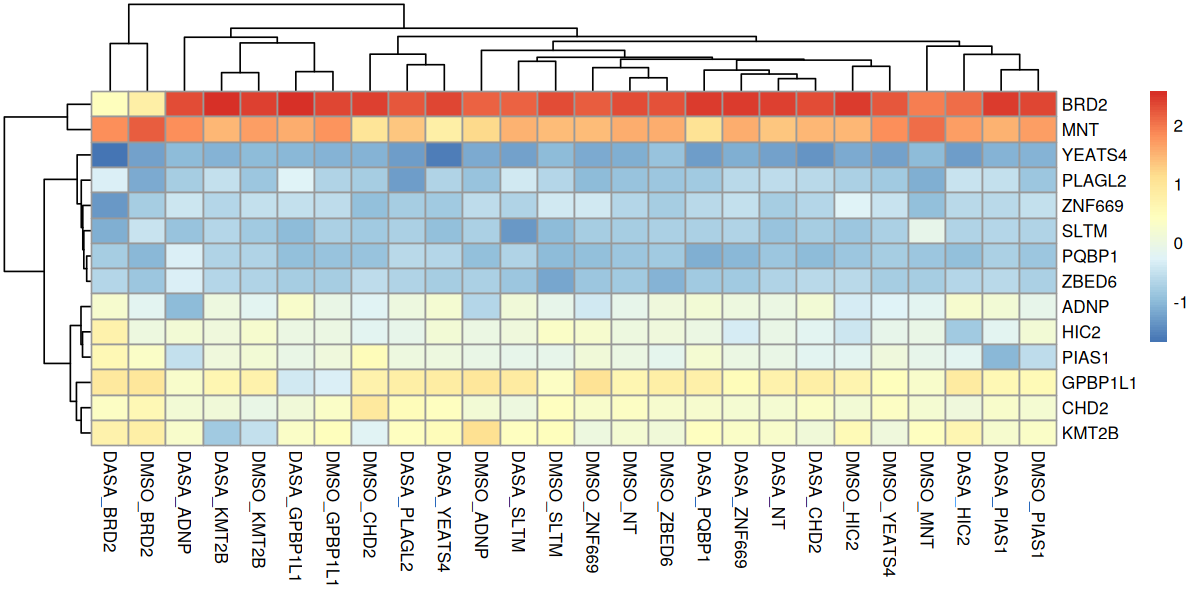

In [33]:
pheatmap(scale(mean_expression), cluster_cols = TRUE, cluster_rows = TRUE)